In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
pip install pyLDAvis

     |████████████████████████████████| 1.7 MB 8.1 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 15.7 MB 23.4 MB/s 
     |████████████████████████████████| 11.3 MB 28.9 MB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136897 sha256=1b8d9f2ec1b97ad8512884db496b458a22484e8f4dc29303f3e600a940785fa4
  Stored in directory: /root/.cache/pip/wheels/c9/21/f6/17bcf2667e8a68532ba2fbf6d5c72fdf4c7f7d9abfa4852d2f
Successfully built pyLDAvis
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
  Attempting uninstall: pandas
    Found existing installation: pandas 1.1.5
    Uninstalling pandas-1.1.5:
      Successfully uninstalled pandas-1.1.5
ERROR: pip's dependency resolver does not currently take in

In [ ]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import spacy
import gensim

from gensim.utils import simple_preprocess
import nltk
from nltk.stem import WordNetLemmatizer
import pyLDAvis
import pyLDAvis.gensim_models

nlp = spacy.load('en')


/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:126: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: Selectable

In [ ]:
parquet_path = '/content/drive/MyDrive/Project datasets/speaker_attributes.parquet'
speaker_attributes = pd.read_parquet(parquet_path)

In [ ]:
dataset2020_csv_path= '/content/drive/MyDrive/ADA_Proj/quotes-2020-clean.csv'
df_2020 = pd.io.json.read_json(dataset2020_csv_path, lines=True, compression='bz2')

In [ ]:
print('Ratio of politicians in the wikidata parquet file is ',politicians_df.shape[0]/speaker_attributes.shape[0])

Ratio of politicians in the wikidata parquet file 0.07256706921094468


In [ ]:
american_quotes= df_2020[df_2020['nationality'].apply(lambda x: False if x is None else 'Q30' in x )]
print('Ratio of american politicians quotes in 2020' ,american_quotes.shape[0]/df_2020.shape[0] )

Ratio of american politicians quotes in 2020 0.4815438612615821


In [ ]:
with_known_degree=df_2020[df_2020['academic_degree'].apply(lambda x: False if (len(x) == 0) else True )]

print('Ratio of quotes with known academic degree of the author',with_known_degree.shape[0]/df_2020.shape[0])

Ratio of quotes with known academic degree of the author 0.18734396810716727


Text(0.5, 1.0, 'Party')

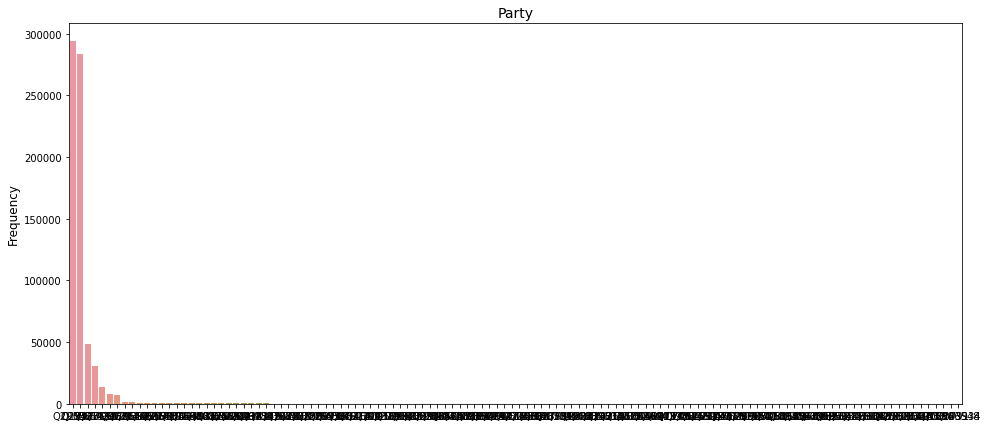

In [ ]:
def adapt(series):
  return pd.Series([x for _list in series for x in _list])

fig, ax = plt.subplots(figsize = (16,7))
sns.barplot(x=adapt(american_quotes['party']).value_counts().index,
        y=adapt(american_quotes['party']).value_counts().values)
ax.set_ylabel("Frequency", size = 12)
ax.set_title("Party", size = 14)

We can see that there is a dominance of two main parties which are the Democratic and Republican one.
Let us see the distribution of the these two compared to all the others. \\
The provided Data is clearely centered around the US and  trying to build a machine learning model that gives conclusions on the whole world would return a highely biased one since 50% of the political quotes are from US politicians. Hence we choose to base our study on the US.

**Analysis**

We thus choose to work on the US politicians, more precisely the Democrats and the Republicans. \\
We will do an in depth analysis of the topics for the years 2015-2020 and try to see if there is actually a difference in the sentiment regarding key topics. \\

In the following notebook, we will analyse the top 20 topics that the politicians talked about, we will then select the relevant ones and study the difference between Republicans and democrats in terms of sentiment. \\
We will also see the importance accorded to certain topics between republicans and Democrats.

In [ ]:
dataset2019_csv_path= '/content/drive/MyDrive/ADA_Proj/quotes-2019-clean.csv'
df_reader = pd.io.json.read_json(dataset2019_csv_path, lines=True, compression='bz2',chunksize=100000)

In [ ]:
def get_americans(df):
 return df[df['nationality'].apply(lambda x: False if x is None else 'Q30' in x )]

In [ ]:
import re
def punctuation(df):
  # Remove punctuation
  df['quotation_processed'] =   df['quotation'].map(lambda x: re.sub('[\[\],\.!?]', '', x))
  # Convert to lowercase
  df['quotation_processed'] =   df['quotation_processed'].map(lambda x: x.lower())
  return df

<input>:4: DeprecationWarning: invalid escape sequence \[
<input>:4: DeprecationWarning: invalid escape sequence \[
<input>:4: DeprecationWarning: invalid escape sequence \[
<input>:4: DeprecationWarning: invalid escape sequence \[
<ipython-input-6-d98ceb80fa61>:4: DeprecationWarning: invalid escape sequence \[
  df['quotation_processed'] =   df['quotation'].map(lambda x: re.sub('[\[\],\.!?]', '', x))


In [ ]:
import nltk
lemmatizer = WordNetLemmatizer()
spacy_stopwords = spacy.lang.en.stop_words.STOP_WORDS
def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
def remove_stopwords(texts):
    return [[lemmatizer.lemmatize(word) for word in simple_preprocess(str(doc)) 
             if word not in spacy_stopwords] for doc in texts]



In [ ]:
import nltk
nltk.download('wordnet')
def get_data_words(df):
  data = df.quotation_processed.values.tolist()
  data_words = list(sent_to_words(data))
  # remove stop words
  data_words = remove_stopwords(data_words)
  return data_words

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


After defining the prerocessing methods, Let us define the dictionnary and the corpus that will help us build the models and visualise them 

In [ ]:
from gensim.corpora import Dictionary
dictionary = Dictionary()
mydf=[]
for data in df_reader:

  df = get_americans(data)
  df = punctuation(df)
  mydf.append(df)
  data_words = get_data_words(df)
  dictionary.add_documents(data_words)
my_df= pd.concat(mydf, ignore_index=True)

# Remove rare and common tokens.
# Filter out words that occur too frequently or too rarely.
max_freq = 0.5
min_wordcount = 5
dictionary.filter_extremes(no_below=min_wordcount, no_above=max_freq)

# Bag-of-words representation of the documents.
#corpus = [dictionary.doc2bow(doc) for doc in data_words]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
dictionary.save('/content/drive/MyDrive/ADA_Proj/2019_dictionary')

/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)


In [ ]:
df_reader = pd.io.json.read_json(dataset2019_csv_path, lines=True, compression='bz2',chunksize=100000)
corpus=[]
for df in df_reader:
  df = get_americans(df)
  df = punctuation(df)
  data_words = get_data_words(df)
  corpus = corpus + [dictionary.doc2bow(doc) for doc in data_words]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


We ran the models for all the years and saved them on the drive previousely because they take a long time to run

In [ ]:
from gensim.models import LdaMulticore
lda_model = LdaMulticore.load('/content/drive/MyDrive/ADA_Proj/lda_2019.model')

/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)


Whole model visualisation

In [ ]:
data =  pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary)
pyLDAvis.display(data)

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


In [ ]:
pyLDAvis.save_html(data, "/content/drive/MyDrive/ADA_Proj/lda_vis_2019.html")

Cluster 2 talks about the economic policy  \
Cluster 4 talks about social problems \
Cluster 7 talks about the trump administration \\
Cluster 8 talks about war and foreing policy \
Cluster 10 talks about tax policy \
Cluster 13 talks about the mueller case (Russian interferrence) \
Cluster 17 talks about immigration.



In [ ]:
to_pro = []
unseen_doc = corpus
vector = lda_model[unseen_doc]
for  t in vector:
  to_pro.append(t)

In [ ]:
y=np.array([np.array(xi) for xi in to_pro])
y.shape

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """Entry point for launching an IPython kernel.


(1406837,)

In [ ]:
cluster_by_quote=[]
for arr in y :
  best_cluster_ind= np.argmax(arr[:,1])
  cluster_by_quote.append(arr[best_cluster_ind])

cluster_by_quote=np.array(cluster_by_quote)
intr =pd.DataFrame(data=cluster_by_quote[:,0], columns=["Cluster_num"])

my_df['Cluster_num']=intr

In [ ]:
pip install vaderSentiment

     |████████████████████████████████| 125 kB 7.6 MB/s 


In [ ]:
import vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()
my_df['compound']=my_df['quotation'].apply(lambda x: analyzer.polarity_scores(x)['compound'])

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
from wordcloud import WordCloud
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use','would','think','know','want'])
def wordclouds(df):
  text=df['quotation_processed'].str.cat(sep=' ')
  text=' '.join([word for word in text.split()])
  wordcloud = WordCloud(background_color = 'white', stopwords = stop_words , max_words = 70).generate(text)
  plt.imshow(wordcloud)
  plt.axis("off")
  plt.show();
  return wordcloud

Let's seperate the republicans and democrats

In [ ]:
republican_df =my_df[my_df['party'].apply(lambda x: False if( x is None)or len(x)==0  else 'Q29468'  in x[-1] )]
democrat_df =my_df[my_df['party'].apply(lambda x: False if (x is None ) or len(x)==0  else 'Q29552'  in x[-1])]

In [ ]:
lda_model.show_topics(num_topics=20)

[(0,
  '0.027*"care" + 0.027*"health" + 0.020*"school" + 0.016*"need" + 0.015*"student" + 0.013*"people" + 0.012*"help" + 0.011*"program" + 0.011*"education" + 0.011*"family"'),
 (1,
  '0.064*"life" + 0.048*"day" + 0.044*"family" + 0.027*"child" + 0.016*"friend" + 0.012*"lost" + 0.012*"time" + 0.011*"heart" + 0.010*"year" + 0.009*"difficult"'),
 (2,
  '0.029*"work" + 0.027*"forward" + 0.024*"bill" + 0.024*"house" + 0.017*"working" + 0.017*"look" + 0.016*"senate" + 0.015*"support" + 0.013*"governor" + 0.013*"proud"'),
 (3,
  '0.118*"president" + 0.068*"trump" + 0.026*"election" + 0.020*"campaign" + 0.017*"political" + 0.016*"impeachment" + 0.015*"donald" + 0.015*"administration" + 0.011*"candidate" + 0.010*"house"'),
 (4,
  '0.032*"money" + 0.030*"year" + 0.026*"tax" + 0.024*"million" + 0.021*"government" + 0.017*"dollar" + 0.017*"company" + 0.015*"billion" + 0.015*"pay" + 0.013*"federal"'),
 (5,
  '0.046*"ll" + 0.043*"decision" + 0.030*"court" + 0.022*"word" + 0.017*"view" + 0.017*"ant

In [ ]:
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()
pyLDAvis.display(gensimvis.prepare(lda_model, corpus, dictionary))


/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


For each topic, we visualise the mean and the variance of the distribution of the sentiment regarding that specific topic. We also check if this distribution is statistically different. We chose to also visualise the wordcloud for some of the topics to see if there is a difference in the used vocabulary.

In [ ]:
democrat_sentiment_economy =democrat_df[democrat_df['Cluster_num']== 18]['compound']
republican_sentiment_economy  =republican_df[republican_df['Cluster_num']== 18]['compound']

In [ ]:
economy_quotes=democrat_df[democrat_df['Cluster_num']== 18]
economy_quotes.iloc[30]['quotation']

"Agriculture is a vital component of our state's economy and I'm pleased to see opportunities for urban agriculture -- like this greenhouse expansion,"

In [ ]:
print('Mean of the sentiment of democrats regarding economy ',democrat_sentiment_economy.mean())
print('Mean of the sentiment of republicans regarding economy',republican_sentiment_economy.mean())

print('Variance of the sentiment of democrats regarding economy',democrat_sentiment_economy.var())
print('Variance of the sentiment of republicans regarding economy',republican_sentiment_economy.var())

ttest = ttest_ind(democrat_sentiment_economy,republican_sentiment_economy)
print(ttest)
print('The difference in the sentiment regarding economy is  significant: ', ttest.pvalue<0.01)

Mean of the sentiment of democrats regarding economy  0.25026638121187844
Mean of the sentiment of republicans regarding economy 0.2789489105745738
Variance of the sentiment of democrats regarding economy 0.22640721994375937
Variance of the sentiment of republicans regarding economy 0.2103618339700406
Ttest_indResult(statistic=-10.032585873409127, pvalue=1.1222948503997153e-23)
The difference in the sentiment regarding economy is  significant:  True


Let's study the sentiment of each party regarding Trump Administration

In [ ]:
democrat_sentiment_trump =democrat_df[democrat_df['Cluster_num']== 3]['compound']
republican_sentiment_trump =republican_df[republican_df['Cluster_num']== 3]['compound']

In [ ]:
print('Mean of the sentiment of democrats regarding Trump Admninistration',democrat_sentiment_trump.mean())
print('Mean of the sentiment of republicans regarding Trump Admninistration',republican_sentiment_trump.mean())

Mean of the sentiment of democrats regarding Trump Admninistration 0.016242133682589845
Mean of the sentiment of republicans regarding Trump Admninistration 0.004878265040427575


In [ ]:
print('Variance of the sentiment of democrats regarding Trump Admninistration',democrat_sentiment_trump.var())
print('Variance of the sentiment of republicans regarding Trump Admninistration',republican_sentiment_trump.var())

Variance of the sentiment of democrats regarding Trump Admninistration 0.191073908721719
Variance of the sentiment of republicans regarding Trump Admninistration 0.18600312315980633


In [ ]:
from scipy.stats import ttest_ind

Text(0.5, 0, 'Sentiment')

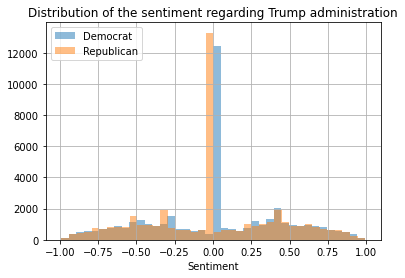

In [ ]:
democrat_sentiment_trump.hist(bins=40, alpha=0.5)
ax = republican_sentiment_trump.hist(bins=40, alpha=0.5)
ax.legend(labels=['Democrat','Republican'],loc='upper left')
ax.set_title('Distribution of the sentiment regarding Trump administration')
plt.xlabel('Sentiment')

In [ ]:
ttest = ttest_ind(democrat_sentiment_trump,republican_sentiment_trump)
print(ttest)
print('The difference in the sentiment regarding Trump Admninistration is significant: ', ttest.pvalue<0.01)

Ttest_indResult(statistic=3.8664957799708204, pvalue=0.00011049030852437126)
The difference in the sentiment regarding Trump Admninistration is significant:  True


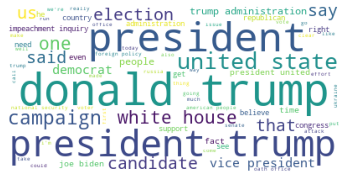

In [ ]:
wordclouds(democrat_df[democrat_df['Cluster_num']== 3])

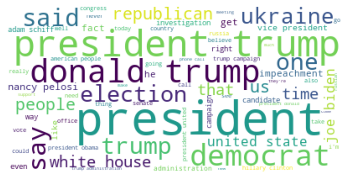

In [ ]:
wordclouds(republican_df[republican_df['Cluster_num']== 3])

Let's now take a look at War , foreign policy

In [ ]:
democrat_sentiment_war =democrat_df[democrat_df['Cluster_num']== 6]['compound']
republican_sentiment_war =republican_df[republican_df['Cluster_num']== 6]['compound']

In [ ]:
print('Mean of the sentiment of democrats regarding war and foreing policy',democrat_sentiment_war.mean())
print('Mean of the sentiment of republicans regarding war and foreign policy',republican_sentiment_war.mean())

Mean of the sentiment of democrats regarding war and foreing policy 0.08060513657683979
Mean of the sentiment of republicans regarding war and foreign policy 0.11373708133394587


In [ ]:
print('Variance of the sentiment of democrats regarding foreign policy',democrat_sentiment_war.var())
print('Variance of the sentiment of republicans regarding foreign policy',republican_sentiment_war.var())

Variance of the sentiment of democrats regarding foreign policy 0.2665699801773475
Variance of the sentiment of republicans regarding foreign policy 0.2683763270667284


Text(0.5, 0, 'Sentiment')

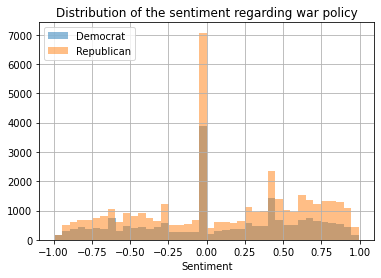

In [ ]:
democrat_sentiment_war.hist(bins=40, alpha=0.5)
ax = republican_sentiment_war.hist(bins=40, alpha=0.5)
ax.legend(labels=['Democrat','Republican'],loc='upper left')
ax.set_title('Distribution of the sentiment regarding war policy')
plt.xlabel('Sentiment')

In [ ]:
ttest = ttest_ind(democrat_sentiment_war,republican_sentiment_war)
print(ttest)
print('The difference in the sentiment regarding war and foreign policy is significant: ', ttest.pvalue<0.01)

Ttest_indResult(statistic=-7.647564732894586, pvalue=2.0770421951328913e-14)
The difference in the sentiment regarding war and foreign policy is significant:  True


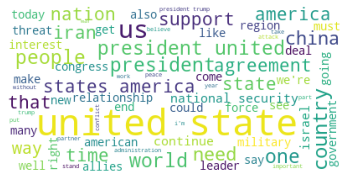

In [ ]:
wordclouds(democrat_df[democrat_df['Cluster_num']== 6])

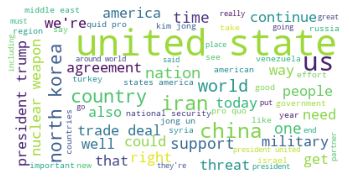

In [ ]:
wordclouds(republican_df[republican_df['Cluster_num']== 6])

Sentiment about tax policy

In [ ]:
democrat_sentiment_Tax =democrat_df[democrat_df['Cluster_num']== 4]['compound']
republican_sentiment_Tax =republican_df[republican_df['Cluster_num']== 4]['compound']

In [ ]:
print('Mean of the sentiment of democrats regarding Tax policy',democrat_sentiment_Tax.mean())
print('Mean of the sentiment of republicans regarding Tax policy',republican_sentiment_Tax.mean())

Mean of the sentiment of democrats regarding Tax policy -0.005347399508813342
Mean of the sentiment of republicans regarding Tax policy 0.012349748506228237


In [ ]:
print('Variance of the sentiment of democrats regarding Tax policy',democrat_sentiment_Tax.var())
print('Variance of the sentiment of republicans regarding Tax policy',republican_sentiment_Tax.var())

Variance of the sentiment of democrats regarding Tax policy 0.17610560897037383
Variance of the sentiment of republicans regarding Tax policy 0.16894661653757456


In [ ]:
ttest = ttest_ind(democrat_sentiment_Tax,republican_sentiment_Tax)
print(ttest)
print('The difference in the sentiment regarding Tax policy is significant: ', ttest.pvalue<0.01)

Ttest_indResult(statistic=-5.28872699362825, pvalue=1.2358853872725187e-07)
The difference in the sentiment regarding Tax policy is significant:  True


Sentiment regarding Mueller Case

In [ ]:
democrat_sentiment_mueller =democrat_df[democrat_df['Cluster_num']== 7]['compound']
republican_sentiment_mueller =republican_df[republican_df['Cluster_num']== 7]['compound']

In [ ]:
print('Mean of the sentiment of democrats regarding Mueller Case',democrat_sentiment_mueller.mean())
print('Mean of the sentiment of republicans regarding Mueller Case',republican_sentiment_mueller.mean())

print('Variance of the sentiment of democrats regarding Mueller Case',democrat_sentiment_mueller.var())
print('Variance of the sentiment of republicans regarding Mueller Case',republican_sentiment_mueller.var())

ttest = ttest_ind(democrat_sentiment_mueller,republican_sentiment_mueller)
print(ttest)
print('The difference in the sentiment regarding Mueller Case is  significant: ', ttest.pvalue<0.01)

Mean of the sentiment of democrats regarding Mueller Case 0.007039945511157224
Mean of the sentiment of republicans regarding Mueller Case -0.01886694267246849
Variance of the sentiment of democrats regarding Mueller Case 0.17281631066611644
Variance of the sentiment of republicans regarding Mueller Case 0.17599107000516573
Ttest_indResult(statistic=6.708947140355307, pvalue=1.9826000813586825e-11)
The difference in the sentiment regarding Mueller Case is  significant:  True


In [ ]:
democrat_sentiment_social =democrat_df[democrat_df['Cluster_num']== 0]['compound']
republican_sentiment_social =republican_df[republican_df['Cluster_num']== 0]['compound']

In [ ]:
print('Mean of the sentiment of democrats regarding Social problems',democrat_sentiment_social.mean())
print('Mean of the sentiment of republicans regarding Social problems',republican_sentiment_social.mean())

print('Variance of the sentiment of democrats regarding Social problems',democrat_sentiment_social.var())
print('Variance of the sentiment of republicans regarding Social problems',republican_sentiment_social.var())

ttest = ttest_ind(democrat_sentiment_social,republican_sentiment_social)
print(ttest)
print('The difference in the sentiment regarding Social problems is  significant: ', ttest.pvalue<0.01)

Mean of the sentiment of democrats regarding Social problems 0.2052142270623274
Mean of the sentiment of republicans regarding Social problems 0.21518139141591852
Variance of the sentiment of democrats regarding Social problems 0.23250381540073792
Variance of the sentiment of republicans regarding Social problems 0.21787985586894337
Ttest_indResult(statistic=-3.1157834895379657, pvalue=0.0018351020549920015)
The difference in the sentiment regarding Social problems is  significant:  True


In [ ]:
democrat_sentiment_immigration =democrat_df[democrat_df['Cluster_num']== 17]['compound']
republican_sentiment_immigration =republican_df[republican_df['Cluster_num']== 17]['compound']

In [ ]:
print('Mean of the sentiment of democrats regarding immigration',democrat_sentiment_immigration.mean())
print('Mean of the sentiment of republicans regarding immigration',republican_sentiment_immigration.mean())

print('Variance of the sentiment of democrats regarding immigration',democrat_sentiment_immigration.var())
print('Variance of the sentiment of republicans regarding immigration',republican_sentiment_immigration.var())

ttest = ttest_ind(democrat_sentiment_immigration,republican_sentiment_immigration)
print(ttest)
print('The difference in the sentiment regarding immigration is  significant: ', ttest.pvalue<0.01)

Mean of the sentiment of democrats regarding immigration -0.030850617066290692
Mean of the sentiment of republicans regarding immigration -0.055761774209341794
Variance of the sentiment of democrats regarding immigration 0.2338381997833563
Variance of the sentiment of republicans regarding immigration 0.24008701133871244
Ttest_indResult(statistic=4.927586543528068, pvalue=8.360647860223999e-07)
The difference in the sentiment regarding immigration is  significant:  True


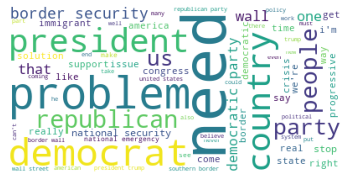

In [ ]:
wordclouds(democrat_df[democrat_df['Cluster_num']== 17])

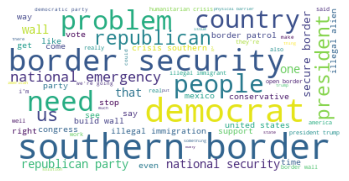

In [ ]:
wordclouds(republican_df[republican_df['Cluster_num']== 17])

**Republican vs Democrat** \\
Topic importance

In [ ]:
df = punctuation(democrat_df)
data_words = get_data_words(df)
corpus = [dictionary.doc2bow(doc) for doc in data_words]
data =  pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary)
pyLDAvis.display(data)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency'

In [ ]:
pyLDAvis.save_html(data, "/content/drive/MyDrive/ADA_Proj/democrat_lda_vis_2019.html")

In [ ]:
df = punctuation(republican_df)
data_words = get_data_words(df)
corpus = [dictionary.doc2bow(doc) for doc in data_words]
data =  pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary)
pyLDAvis.display(data)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency'

In [ ]:
pyLDAvis.save_html(data, "/content/drive/MyDrive/ADA_Proj/republican_lda_vis_2019.html")

Economy subject Through time \\

the following data has been taken from the different years for  specfic topics that have been identified in all the years

Text(0.5, 1.0, 'Sentiment regarding Economic Policy')

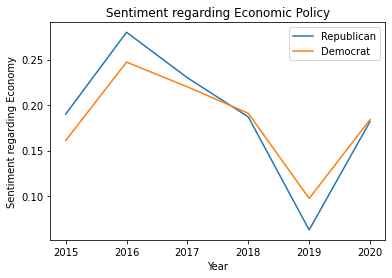

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.errorbar(df_eco.index, df_eco.Democrat_mean,
             capsize= 3)
plt.errorbar(df_eco.index, df_eco.Republican_mean,
             capsize= 3)

plt.legend(labels=['Republican','Democrat'],loc='upper right')
plt.xlabel('Year')
plt.ylabel('Sentiment regarding Economy')
plt.title('Sentiment regarding Economic Policy')

Let's study the importance of different topics for republicans and democrats throught time 

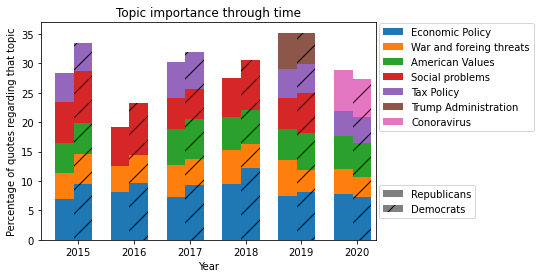

In [ ]:
import pandas as pd
import matplotlib.cm as cm
import numpy as np
import matplotlib.pyplot as plt

def plot_clustered_stacked(dfall, labels=None, title="multiple stacked bar plot",  H="/", **kwargs):

    n_df = len(dfall)
    n_col = len(dfall[0].columns) 
    n_ind = len(dfall[0].index)
    axe = plt.subplot(111)

    for df in dfall : # for each data frame
        axe = df.plot(kind="bar",
                      linewidth=0,
                      stacked=True,
                      ax=axe,
                      legend=False,
                      grid=False,
                      **kwargs)  # make bar plots

    h,l = axe.get_legend_handles_labels() # get the handles we want to modify
    for i in range(0, n_df * n_col, n_col): # len(h) = n_col * n_df
        for j, pa in enumerate(h[i:i+n_col]):
            for rect in pa.patches: # for each index
                rect.set_x(rect.get_x() + 1 / float(n_df + 1) * i / float(n_col))
                rect.set_hatch(H * int(i / n_col)) #edited part     
                rect.set_width(1 / float(n_df + 1))

    axe.set_xticks((np.arange(0, 2 * n_ind, 2) + 1 / float(n_df + 1)) / 2.)
    axe.set_xticklabels(df.index, rotation = 0)
    axe.set_title(title)

    # Add invisible data to add another legend
    n=[]        
    for i in range(n_df):
        n.append(axe.bar(0, 0, color="gray", hatch=H * i))

    l1 = axe.legend(h[:n_col], l[:n_col], loc=[1.01, 0.5])
    if labels is not None:
        l2 = plt.legend(n, labels, loc=[1.01, 0.1]) 
    axe.add_artist(l1)
    plt.title('Topic importance through time')
    plt.ylabel('Percentage of quotes regarding that topic')
    plt.savefig('/content/drive/MyDrive/ADA_Proj/stacked.png')
    return axe
# Then, just call :
plot_clustered_stacked([df_rep.set_index('Year'), df_dem.set_index('Year')],["Republicans", "Democrats"])

In [ ]:
Economic_policy_vals=[[0.310,0.333],[0.282180,0.3085293],[ 0.15798,0.12329],[0.190,0.187],[ 0.215181,0.205214],[0.3008985,0.247852]]

df_eco = pd.DataFrame(Economic_policy_vals, index=[2015,2016,2017,2018,2019,2020],columns =['Republican_mean','Democrat_mean'])

Text(0.5, 1.0, 'Sentiment regarding Economic Policy')

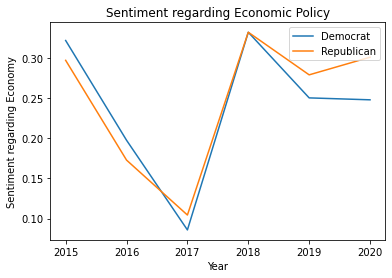

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.errorbar(df_eco.index, df_eco.Democrat_mean,
             capsize= 3)
plt.errorbar(df_eco.index, df_eco.Republican_mean,
             capsize= 3)

plt.legend(labels=['Democrat','Republican'],loc='upper right')
plt.xlabel('Year')
plt.ylabel('Sentiment regarding Economy')
plt.title('Sentiment regarding Economic Policy')

In [ ]:
social_policy_vals=[[0.297,0.3216951],[0.1727914,0.1975108],[0.104381,0.085843],[0.332,0.332],[0.278948,0.25026],[0.13266,0.132383]]

df_eco = pd.DataFrame(Economic_policy_vals, index=[2015,2016,2017,2018,2019,2020],columns =['Republican_mean','Democrat_mean'])

Text(0.5, 1.0, 'Sentiment regarding Social Problems')

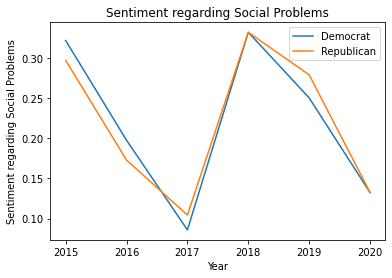

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.errorbar(df_eco.index, df_eco.Democrat_mean,
             capsize= 3)
plt.errorbar(df_eco.index, df_eco.Republican_mean,
             capsize= 3)

plt.legend(labels=['Democrat','Republican'],loc='upper right')
plt.xlabel('Year')
plt.ylabel('Sentiment regarding Social Problems')
plt.title('Sentiment regarding Social Problems')

In [ ]:
War_policy_vals=[[-0.018,0.0611],[-0.04708,-0.011292],[-0.17727,-0.2267845],[0.137,0.0863],[0.11373,0.0806],[-0.221859,-0.2174437]]

df_eco = pd.DataFrame(Economic_policy_vals, index=[2015,2016,2017,2018,2019,2020],columns =['Republican_mean','Democrat_mean'])

Text(0.5, 1.0, 'Sentiment regarding War and foreing policy')

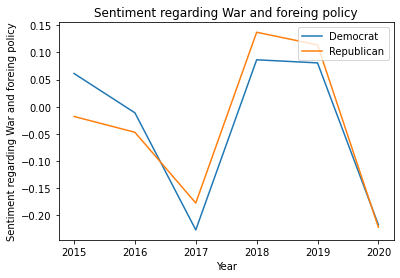

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.errorbar(df_eco.index, df_eco.Democrat_mean,
             capsize= 3)
plt.errorbar(df_eco.index, df_eco.Republican_mean,
             capsize= 3)

plt.legend(labels=['Democrat','Republican'],loc='upper right')
plt.xlabel('Year')
plt.ylabel('Sentiment regarding War and foreing policy')
plt.title('Sentiment regarding War and foreing policy')